<a href="https://colab.research.google.com/github/dmahdipour/pytorch/blob/main/MultiClass_ConvolutionalNeuralNetwordModel_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import requests

from pathlib import Path

from timeit import default_timer as timer

from tqdm.auto import tqdm

import pandas as pd

import random

In [2]:
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

In [3]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.5 MB/s eta 0:00:00
mlxtend version: 0.22.0


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
def print_train_timer(start: float,
                      end: float,
                      device: torch.device = None):
  total_time=end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [6]:
train_data = datasets.MNIST(
    root="Data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="Data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 9912422/9912422 [00:00<00:00, 101312004.55it/s]


Extracting Data/MNIST/raw/train-images-idx3-ubyte.gz to Data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 108060387.00it/s]


Extracting Data/MNIST/raw/train-labels-idx1-ubyte.gz to Data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26902441.71it/s]


Extracting Data/MNIST/raw/t10k-images-idx3-ubyte.gz to Data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23260718.89it/s]


Extracting Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to Data/MNIST/raw



In [7]:
len(train_data), len(test_data)

(60000, 10000)

In [8]:
class_name = train_data.classes
class_label = torch.unique(train_data.targets)
class_to_idx = train_data.class_to_idx

print(class_name, class_label)
print(class_to_idx)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'] tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


In [9]:
image, label = train_data[0]
print(f"ImageSgape: {image.shape} \nImage Label: {label} ({class_name[label]})")

ImageSgape: torch.Size([1, 28, 28]) 
Image Label: 5 (5 - five)


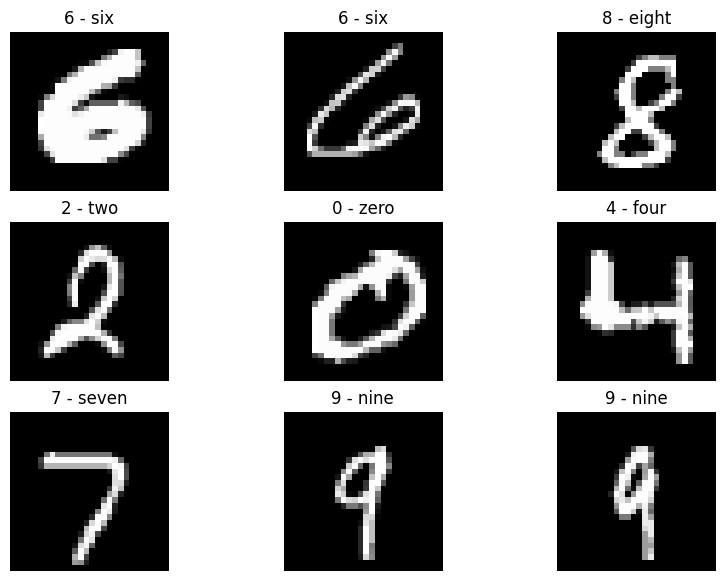

In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

fig = plt.figure(figsize=(10,7))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(class_name[label])
  plt.axis(False)

In [11]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [12]:
class MNIST_CNN_Model(nn.Module):
  """
    Model architecture is TinyVGG
  """
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x:torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = MNIST_CNN_Model(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_name)).to(device)

model

MNIST_CNN_Model(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [14]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimzer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):
  train_loss, train_acc = 0, 0
  for X,y in data_loader:
    X, y = X.to(device), y.to(device)

    model.train()
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train_Loss: {train_loss:.5f} | Train_Acc: {train_acc:.2f}%")

In [15]:
def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device=device):
  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y,
                              y_pred=y_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test_Loss: {test_loss:.5f} | Test_Acc: {test_acc:.2f}%\n")

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)
epochs=3

torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start = timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----------")
  train_step(data_loader=train_dataloader,
             model=model,
             loss_fn=loss_fn,
             optimzer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(data_loader=test_dataloader,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_stop = timer()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Train_Loss: 0.33399 | Train_Acc: 88.79%
Test_Loss: 0.07535 | Test_Acc: 97.68%

Epoch: 1
----------
Train_Loss: 0.08207 | Train_Acc: 97.43%
Test_Loss: 0.06989 | Test_Acc: 97.72%

Epoch: 2
----------
Train_Loss: 0.06439 | Train_Acc: 97.98%
Test_Loss: 0.06197 | Test_Acc: 97.94%



In [17]:
total_train_time_model = print_train_timer(start=train_time_start,
                                           end=train_time_stop,
                                           device=device)

Train time on cuda: 54.454 seconds


In [18]:
def eval_model(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               accuracy_fn):
  """(Dict): Returns a dictionary containing the results of model predicting on data_loader."""

  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss += loss_fn(y_pred, y)
        acc += accuracy_fn(y_true=y,
                           y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [19]:
model_results = eval_model(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_results

{'model_name': 'MNIST_CNN_Model',
 'model_loss': 0.06196632981300354,
 'model_acc': 97.94329073482429}

In [20]:
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device=device):
  pred_probs = []

  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_prob = torch.softmax(model(sample).squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)

In [21]:
random.seed(42)

test_samples, test_labels = [], []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

pred_classes = make_predictions(model=model, data=test_samples).argmax(dim=1)

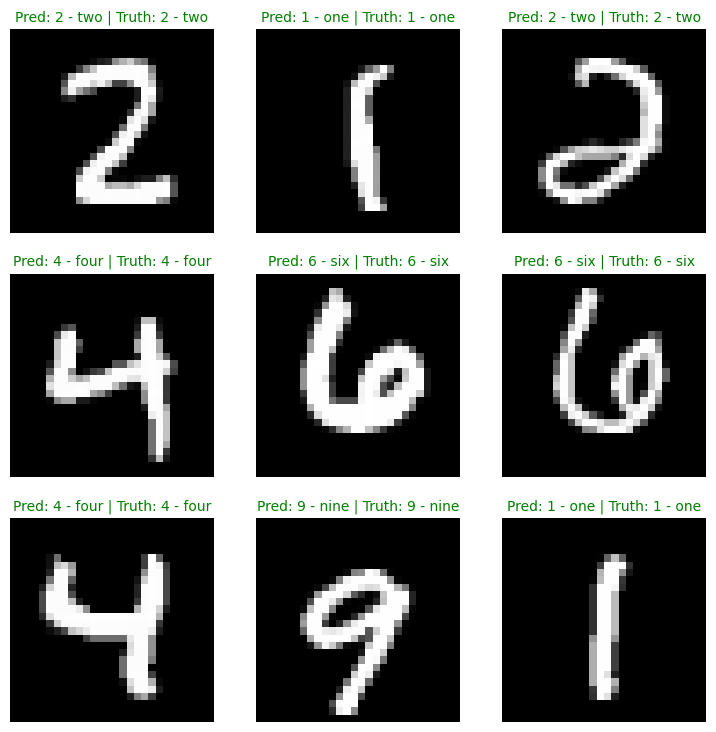

In [22]:
plt.figure(figsize=(9, 9))
rows = 3
cols = 3

for i, sample in enumerate(test_samples):
  plt.subplot(rows, cols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = class_name[pred_classes[i]]
  truth_label = class_name[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
  else:
      plt.title(title_text, fontsize=10, c="r")
  plt.axis(False);

In [23]:
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):

    X, y = X.to(device), y.to(device)
    y_logit = model(X)

    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

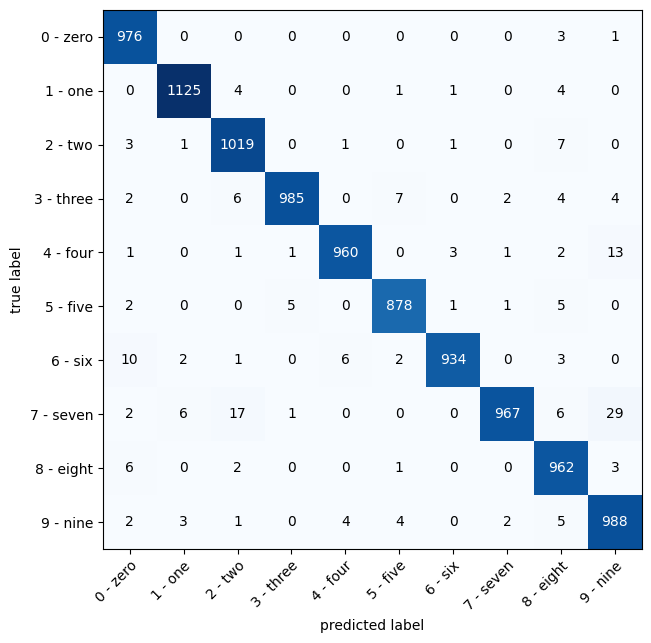

In [24]:
confmat = ConfusionMatrix(num_classes=len(class_name), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_name,
    figsize=(10, 7)
);

In [25]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True
)

MODEL_NAME = "MultiClass_ConvolutionalNeuralNetwordModel_FashionMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/MultiClass_ConvolutionalNeuralNetwordModel_FashionMNIST.pth
